In [41]:
"""
plot, showcasing the Hodgkin Huxley Neuron Dynmics
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

#==============================================================================#


def HH(_I=6.5,
       g_Na=120.,
       g_K=36.,
       g_Leak=0.3,
       E_Na=50.,
       E_K=-77.,
       E_Leak=-54.387):

    ######### Constants
    C_m = 1.  # Membrane Capacitance

    ######### Gating Kinetics
    m_alpha =       lambda V: 0.1 * (V + 40.0) / (1.0 - np.exp(-(V + 40.0) / 10.0))
    m_beta  =       lambda V: 4.0 * np.exp(-(V + 65.0) / 18.0)
    h_alpha =       lambda V: 0.07 * np.exp(-(V + 65.0) / 20.0)
    h_beta  =       lambda V: 1.0 / (1.0 + np.exp(-(V+35.0) / 10.0))
    n_alpha =       lambda V: 0.01 * (V + 55.0) / (1.0 - np.exp(-(V + 55.0) / 10.0))
    n_beta  =       lambda V: 0.125 * np.exp(-(V + 65) / 80.0)

    ######### Ion Currents
    I_Na    =       lambda V, m, h:     g_Na * m**3 * h * (V - E_Na)
    I_K     =       lambda    V, n:     g_K * n**4 * (V - E_K)
    I_Leak  =       lambda       V:     g_Leak * (V - E_Leak)

    ######### Experimental Setup
    # TIME
    T       =       400                       # total simulation length
    dt      =       0.1                       # step size
    time    =       np.arange(0, T+dt, dt)    # step values
    # CURRENT

    def I(t):
        return _I * (40 < t < 300)

    # Function to odeint over
    def change(X, t):
        V, m, h, n = X

        #calculate membrane potential & activation variables
        dV = (I(t) - I_Na(V, m, h) - I_K(V, n) - I_Leak(V)) / C_m
        dm = m_alpha(V) * (1.0 -m ) - m_beta(V) * m
        dh = h_alpha(V) * (1.0 - h) - h_beta(V) * h
        dn = n_alpha(V) * (1.0 - n) - n_beta(V) * n
        return dV, dm, dh, dn


    # integrate over all 4 differential equations, use following initial conditions
    all_changes = odeint(change, [-65, 0.05, 0.6, 0.32], time)
    V = all_changes[:,0]
    m = all_changes[:,1]
    h = all_changes[:,2]
    n = all_changes[:,3]

    I = np.zeros(len(time))
    I[400:3000] = _I

    # also return used params as dict
    params = {
        "membrane capacitance [uF/cm^2]" : C_m,
        "maximum sodium conductance [mS/cm^2]" : g_Na,
        "maximum potassium conductance [mS/cm^2]" : g_K,
        "maximum leak conductance [mS/cm^2]" : g_Leak,
        "sodium nernst reversal potential [mV]" : E_Na,
        "potassium nernst reversal potential [mV]" : E_K,
        "leaks nernst reversal potential [mV]" : E_Leak,
        "step size [ms]" : dt
    }
    
    return time, V, I, m, h, n, params

In [42]:

"""
plot, showcasing the Izhikevich Model dynamics and the
diverse neuron types it can adapt to
"""

# import numpy as np
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import  Button, Slider

#==============================================================================#

def Izhikevich_Model(_I = 10, a = 0.02, b = 0.2, c = -65, d = 8):

    ######### Constants
    spike_value = 35                            # Maximal Spike Value

    ######### Experimental Setup
    # TIME
    T               =   400                    # total simulation length [ms]
    dt              =   0.1                     # step size [ms]
    time            =   np.arange(0, T+dt, dt)  # step values [ms]
    # VOLTAGE
    V               =   np.zeros(len(time))     # array for saving voltage history
    V[0]            =   -70                     # set initial to resting potential
    # RECOVERY
    u               =   np.zeros(len(time))     # array for saving Recovery history
    u[0]            =   -14
    # CURRENT
    I = np.zeros(len(time))
    I[400:3000] = _I

    for t in range(1, len(time)):
        # if we still didnt reach spike potential
        if V[t-1] < spike_value:
            # ODE for membrane potential
            dV      = (0.04 * V[t-1] + 5) * V[t-1] + 140 - u[t-1]
            V[t]    = V[t-1] + (dV + I[t-1]) * dt
            # ODE for recovery variable
            du      = a * (b * V[t-1] - u[t-1])
            u[t]    = u[t-1] + dt * du
        # spike reached!
        else:
            V[t-1] = spike_value    # set to spike value
            V[t] = c                # reset membrane voltage
            u[t] = u[t-1] + d       # reset recovery

    # also return used params as dict
    params = {
        "Maximal Spike Value" : spike_value,
        "a" : a,
        "b" : b,
        "c" : c,
        "d" : d,
        "step size [ms]" : dt
    }

    return time, V, I, params

In [43]:

"""
plot, showcasing the Leaky Integrate-and-Fire Model
"""

# import numpy as np
# import matplotlib.pyplot as plt

#==============================================================================#

def LIF(_I=25, gl=0.016, Cm=49):

    ######### Constants
    El      =   -65                      # restint membrane potential [V]
    thresh  =   -50                      # spiking threshold [V]

    ######### Experimental Setup
    # TIME
    T       =   400                       # total simulation length [s]
    dt      =   0.001                     # step size [s]
    time    =   np.arange(0, T+dt, dt)      # step values [s]
    # VOLTAGE
    V       =   np.empty(len(time))         # array for saving Voltage history
    V[0]    =   El                          # set initial to resting potential
    # CURRENT
    I = np.zeros(len(time))
    I[40000:300000] = _I
    ######### Measurements
    spikes  =   0                           # counter for number of spikes

    ######### Simulation
    for i in range(1, len(time)):
        # use "I - V/R = C * dV/dT" to get this equation
        dV =  (I[i] - gl*(V[i-1]-El))/Cm
        V[i] = V[i-1] + dV*dt

        # in case we exceed threshold
        if V[i] > thresh:
            V[i-1] = 35   # set the last step to spike value
            V[i] = El       # current step is resting membrane potential
            spikes += 1     # count spike

    # also return used params as dict
    params = {
        "resting membrane potential [V]" : El,
        "spiking threshold [V]" : thresh,
        "leak conductance" : gl,
        "membrane capacitance" : Cm,
        "step size [ms]" : dt
    }
    return time, V, I, params

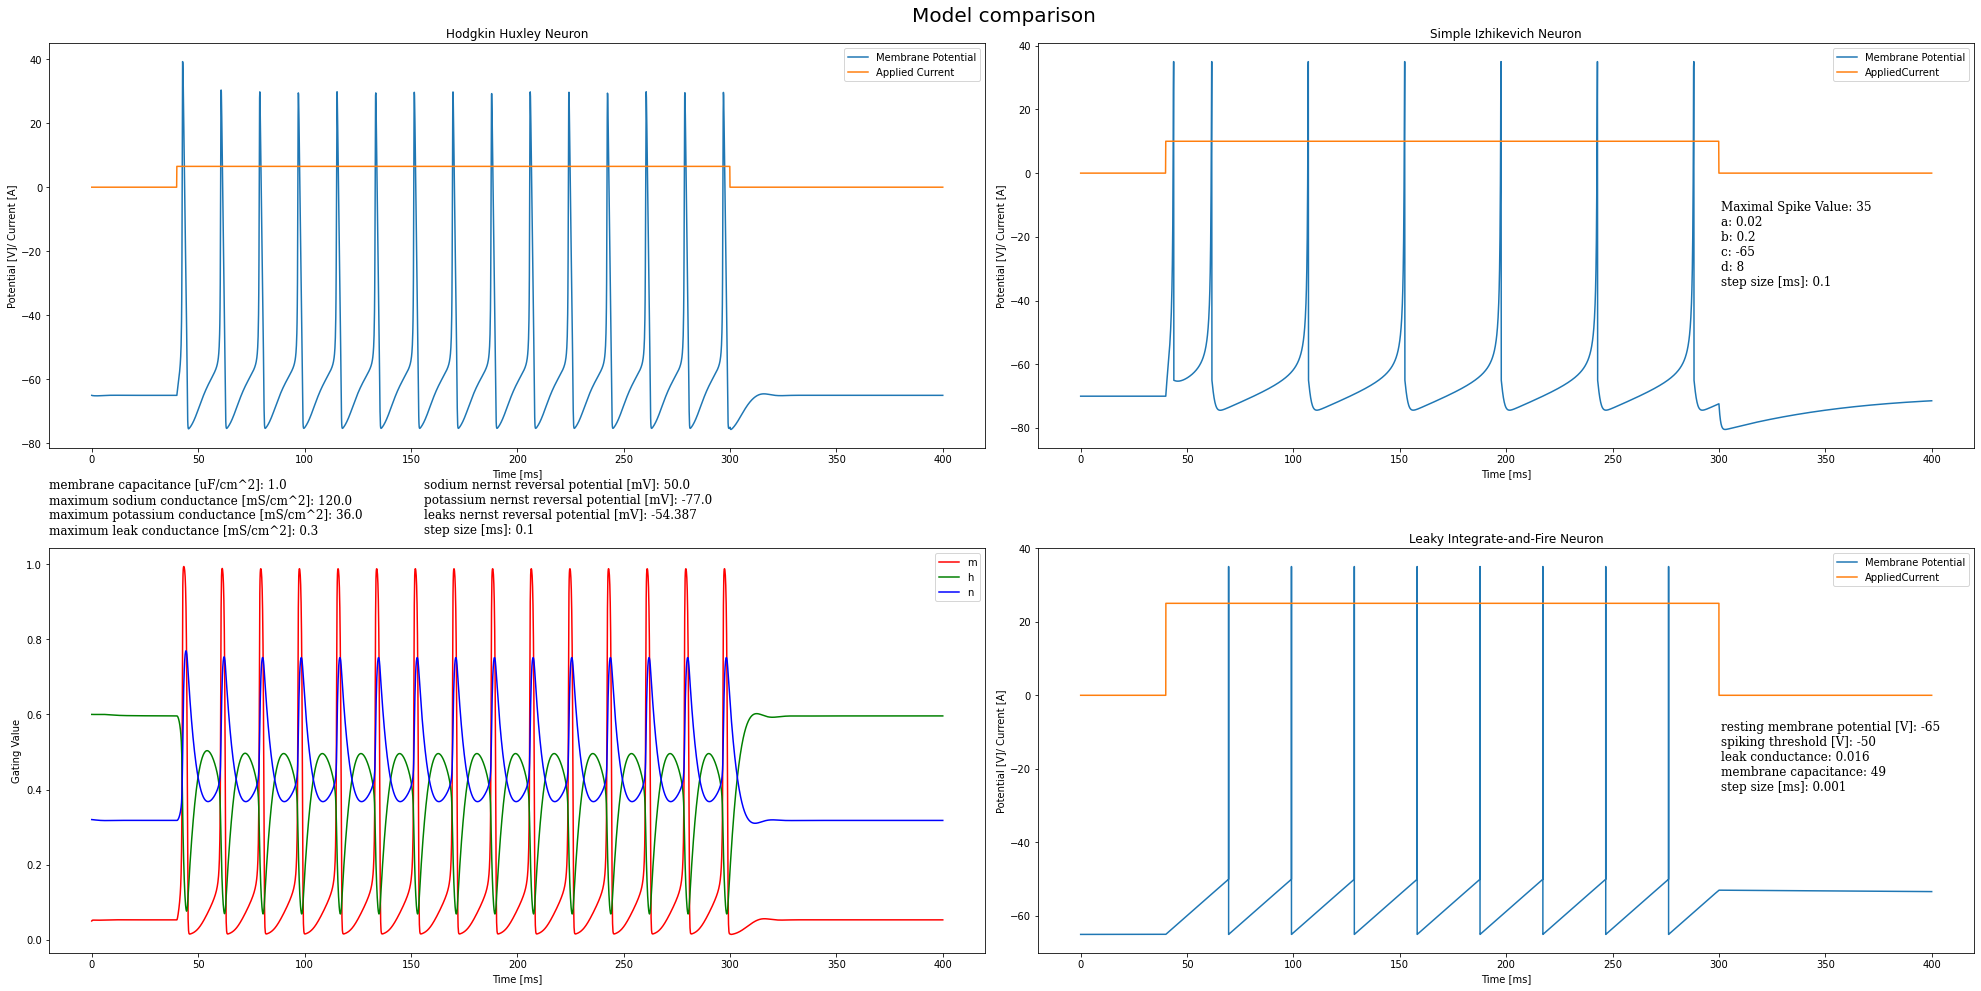

In [44]:
## plotting
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 12,
        }

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(28,14))
## plot HH
time_HH, V_HH, I_HH, m_HH, h_HH, n_HH, params_HH= HH()
axs[0,0].plot(time_HH, V_HH, label="Membrane Potential")
axs[0,0].plot(time_HH, I_HH, label="Applied Current")
# plot legend HH 
axs[0,0].legend(loc="upper right")
# add axis labels HH
axs[0,0].set(title="Hodgkin Huxley Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")
# plot HH args
axs[0,0].text(0,-0.25,f'''membrane capacitance [uF/cm^2]: {params_HH["membrane capacitance [uF/cm^2]"]}
maximum sodium conductance [mS/cm^2]: {params_HH["maximum sodium conductance [mS/cm^2]"]}
maximum potassium conductance [mS/cm^2]: {params_HH["maximum potassium conductance [mS/cm^2]"]}
maximum leak conductance [mS/cm^2]: {params_HH["maximum leak conductance [mS/cm^2]"]}
''',transform=axs[0,0].transAxes, fontdict = font)
axs[0,0].text(0.4,-0.25,f'''sodium nernst reversal potential [mV]: {params_HH["sodium nernst reversal potential [mV]"]}
potassium nernst reversal potential [mV]: {params_HH["potassium nernst reversal potential [mV]"]}
leaks nernst reversal potential [mV]: {params_HH["leaks nernst reversal potential [mV]"]}
step size [ms]: {params_HH["step size [ms]"]}
''',transform=axs[0,0].transAxes, fontdict = font)

## plot parameters m, h, n HH
axs[1,0].plot(time_HH, m_HH, 'r', label='m')
axs[1,0].plot(time_HH, h_HH, 'g', label='h')
axs[1,0].plot(time_HH, n_HH, 'b', label='n')
# parameters labels
axs[1,0].set(xlabel="Time [ms]", ylabel="Gating Value")
axs[1,0].legend(loc="upper right")


## plot IZ
time_IZ, V_IZ, I_IZ, params_IZ = Izhikevich_Model()
axs[0,1].plot(time_IZ, V_IZ, label="Membrane Potential")
axs[0,1].plot(time_IZ, I_IZ, label="AppliedCurrent")
axs[0,1].legend(loc="upper right")
axs[0,1].set(title="Simple Izhikevich Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")
# add IZ args
axs[0,1].text(0.73,0.4,f'''Maximal Spike Value: {params_IZ["Maximal Spike Value"]}
a: {params_IZ["a"]}
b: {params_IZ["b"]}
c: {params_IZ["c"]}
d: {params_IZ["d"]}
step size [ms]: {params_IZ["step size [ms]"]}''',transform=axs[0,1].transAxes, fontdict = font)


## plot LIF
time_LIF, V_LIF, I_LIF, params_LIF = LIF()
axs[1,1].plot(time_LIF, V_LIF, label="Membrane Potential")
axs[1,1].plot(time_LIF, I_LIF, label="AppliedCurrent")
axs[1,1].legend(loc="upper right")
axs[1,1].set(title="Leaky Integrate-and-Fire Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")
# add LIF args
axs[1,1].text(0.73,0.4,f'''resting membrane potential [V]: {params_LIF["resting membrane potential [V]"]}
spiking threshold [V]: {params_LIF["spiking threshold [V]"]}
leak conductance: {params_LIF["leak conductance"]}
membrane capacitance: {params_LIF["membrane capacitance"]}
step size [ms]: {params_LIF["step size [ms]"]}''',transform=axs[1,1].transAxes, fontdict = font)

# better looks
fig.suptitle(t="Model comparison", fontsize=20)

# # surround HH
# rect_HH = plt.Rectangle(
#     # (lower-left corner), width, height
#     (0, 0), 0.495, 0.962, fill=False, color="k", lw=2, 
#     zorder=1000, transform=fig.transFigure, figure=fig
# )
# # surround IZ
# rect_IZ = plt.Rectangle(
#     # (lower-left corner), width, height
#     (0.495, 0.485), 0.5, 0.477, fill=False, color="k", lw=2, 
#     zorder=1000, transform=fig.transFigure, figure=fig
# )
# # surround LIF
# rect_LIF = plt.Rectangle(
#     # (lower-left corner), width, height
#     (0.495, 0.485), 0.5, -0.485, fill=False, color="k", lw=2, 
#     zorder=1000, transform=fig.transFigure, figure=fig
# )
# fig.patches.extend([rect_HH])
# fig.patches.extend([rect_IZ])
# fig.patches.extend([rect_LIF])
fig.tight_layout()
plt.savefig("model comparison 2x2 with text", facecolor='white')
plt.show()


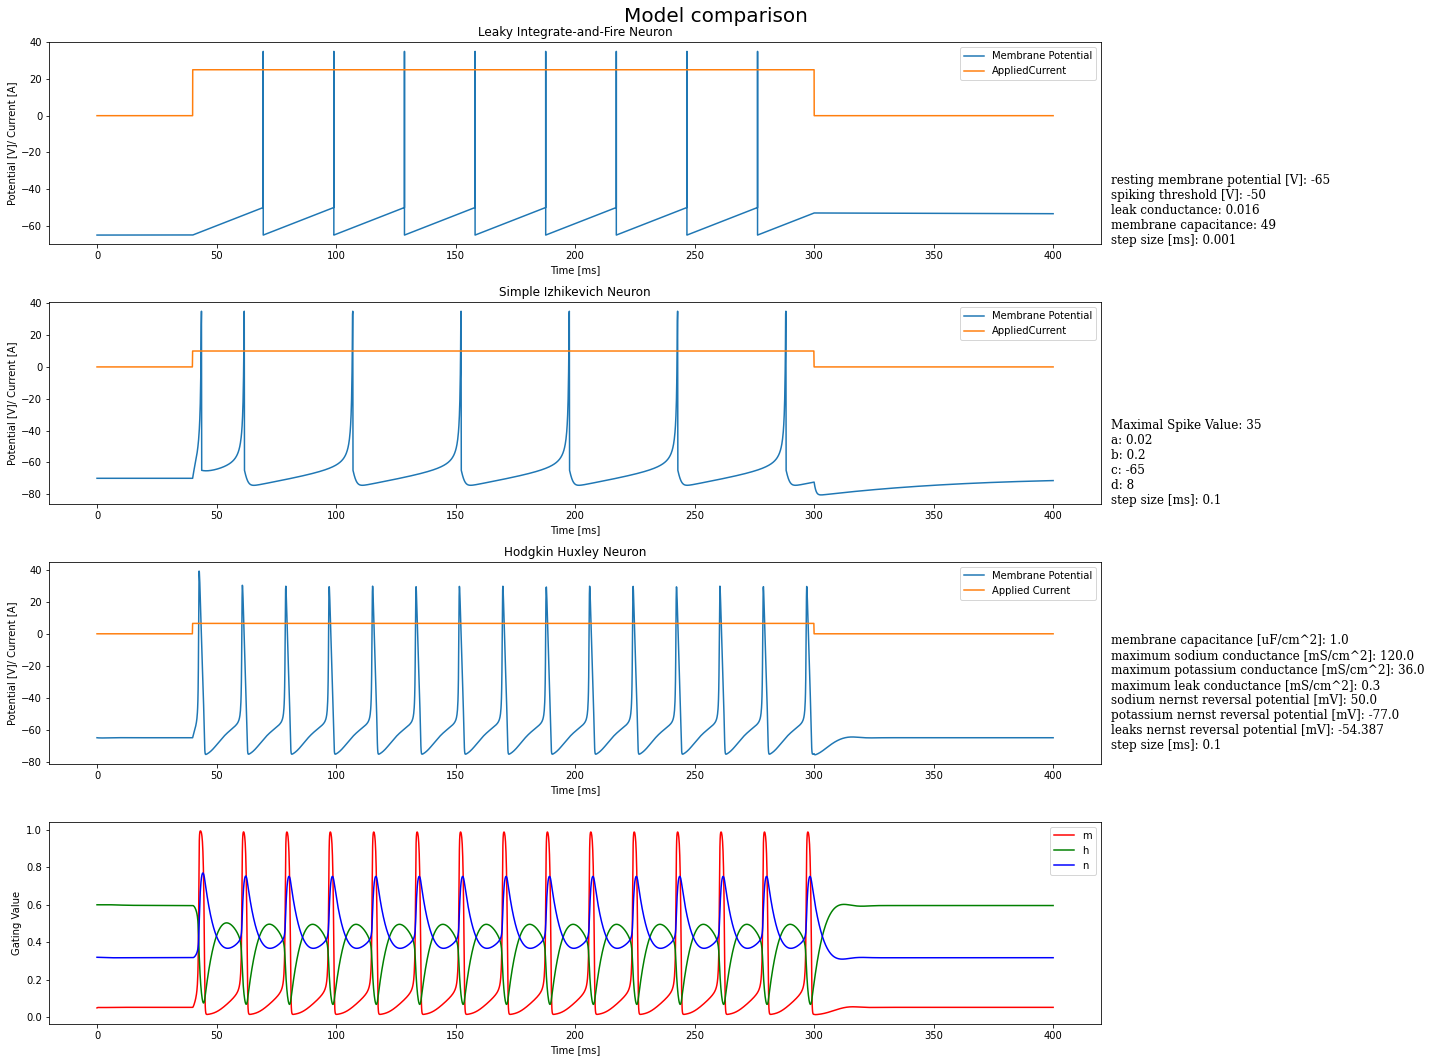

In [45]:
## plotting
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 12,
        }

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20,15))
fig.suptitle(t="Model comparison", fontsize=20)


## plot LIF
time_LIF, V_LIF, I_LIF, params_LIF = LIF()
axs[0].plot(time_LIF, V_LIF, label="Membrane Potential")
axs[0].plot(time_LIF, I_LIF, label="AppliedCurrent")
axs[0].legend(loc="upper right")
axs[0].set(title="Leaky Integrate-and-Fire Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")
# add LIF args
axs[0].text(1.01,0,f'''resting membrane potential [V]: {params_LIF["resting membrane potential [V]"]}
spiking threshold [V]: {params_LIF["spiking threshold [V]"]}
leak conductance: {params_LIF["leak conductance"]}
membrane capacitance: {params_LIF["membrane capacitance"]}
step size [ms]: {params_LIF["step size [ms]"]}''',transform=axs[0].transAxes, fontdict = font)

## plot IZ
time_IZ, V_IZ, I_IZ, params_IZ = Izhikevich_Model()
axs[1].plot(time_IZ, V_IZ, label="Membrane Potential")
axs[1].plot(time_IZ, I_IZ, label="AppliedCurrent")
axs[1].legend(loc="upper right")
axs[1].set(title="Simple Izhikevich Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")
# add IZ args
axs[1].text(1.01,0,f'''Maximal Spike Value: {params_IZ["Maximal Spike Value"]}
a: {params_IZ["a"]}
b: {params_IZ["b"]}
c: {params_IZ["c"]}
d: {params_IZ["d"]}
step size [ms]: {params_IZ["step size [ms]"]}''',transform=axs[1].transAxes, fontdict = font)


## plot HH
time_HH, V_HH, I_HH, m_HH, h_HH, n_HH, params_HH= HH()
axs[2].plot(time_HH, V_HH, label="Membrane Potential")
axs[2].plot(time_HH, I_HH, label="Applied Current")
# plot legend HH 
axs[2].legend(loc="upper right")
# add axis labels HH
axs[2].set(title="Hodgkin Huxley Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")
# plot HH args
axs[2].text(1.01,0,f'''membrane capacitance [uF/cm^2]: {params_HH["membrane capacitance [uF/cm^2]"]}
maximum sodium conductance [mS/cm^2]: {params_HH["maximum sodium conductance [mS/cm^2]"]}
maximum potassium conductance [mS/cm^2]: {params_HH["maximum potassium conductance [mS/cm^2]"]}
maximum leak conductance [mS/cm^2]: {params_HH["maximum leak conductance [mS/cm^2]"]}
sodium nernst reversal potential [mV]: {params_HH["sodium nernst reversal potential [mV]"]}
potassium nernst reversal potential [mV]: {params_HH["potassium nernst reversal potential [mV]"]}
leaks nernst reversal potential [mV]: {params_HH["leaks nernst reversal potential [mV]"]}
step size [ms]: {params_HH["step size [ms]"]}
''',transform=axs[2].transAxes, fontdict = font)

# plot parameters m, h, n HH
axs[3].plot(time_HH, m_HH, 'r', label='m')
axs[3].plot(time_HH, h_HH, 'g', label='h')
axs[3].plot(time_HH, n_HH, 'b', label='n')
# parameters labels
axs[3].set(xlabel="Time [ms]", ylabel="Gating Value")
axs[3].legend(loc="upper right")


# better looks
fig.tight_layout()
plt.savefig("model comparison rows with text", facecolor='white')
plt.show()


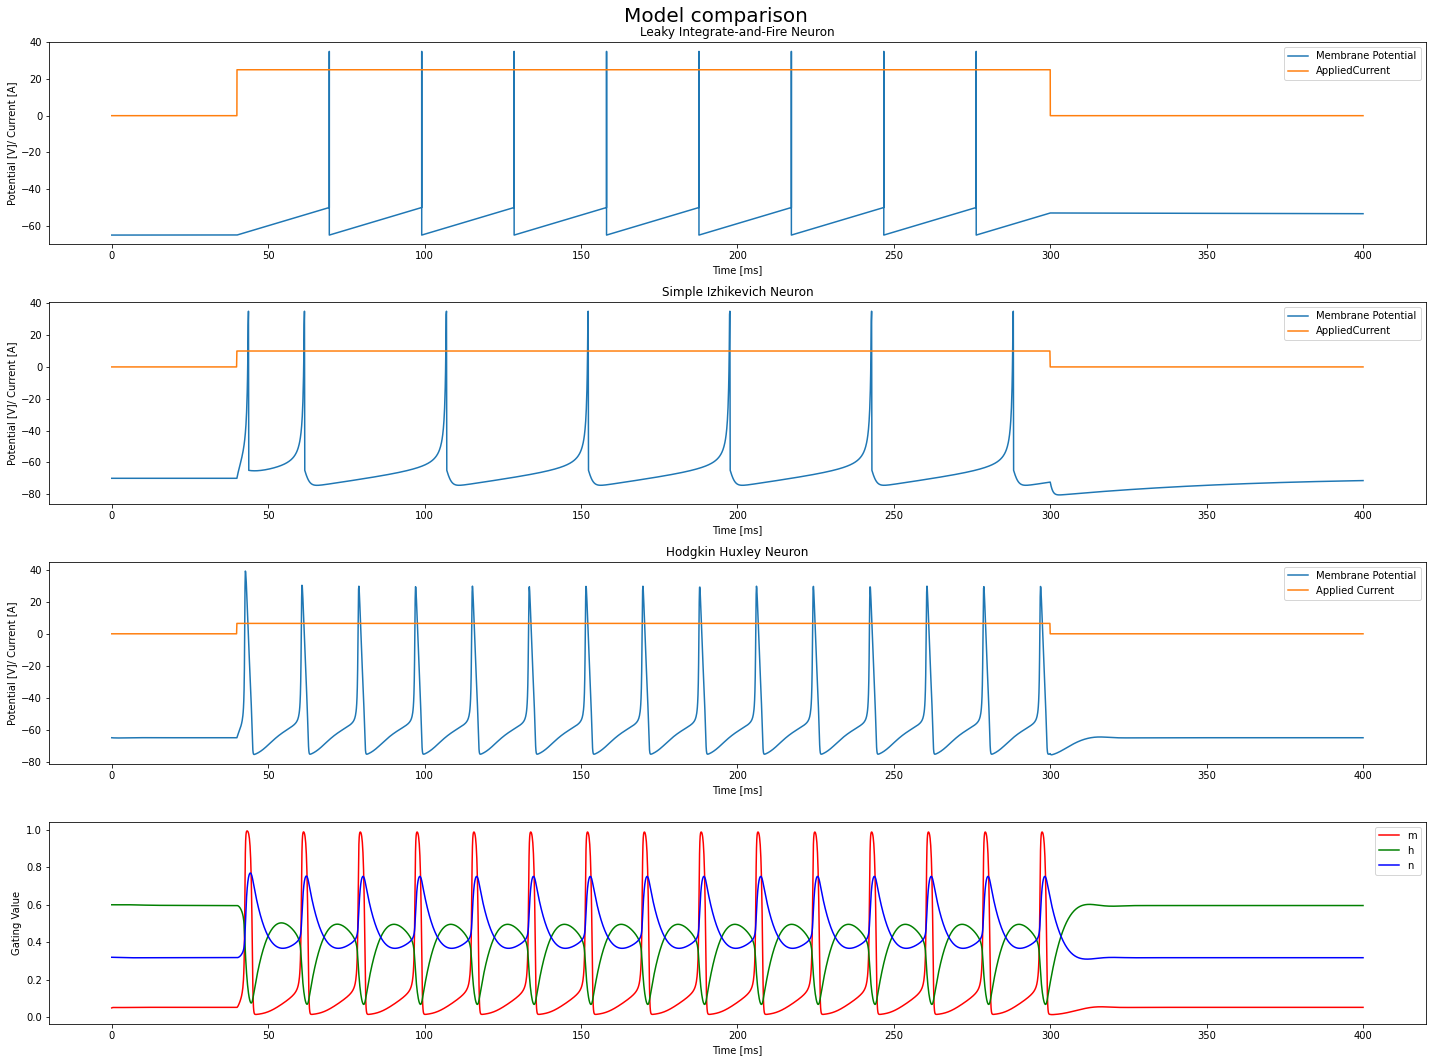

In [46]:
## plotting 4 rows without model param
font = {'family': 'serif',
        'color':  'k',
        'weight': 'normal',
        'size': 12,
        }

fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(20,15))
fig.suptitle(t="Model comparison", fontsize=20)


## plot LIF
time_LIF, V_LIF, I_LIF, params_LIF = LIF()
axs[0].plot(time_LIF, V_LIF, label="Membrane Potential")
axs[0].plot(time_LIF, I_LIF, label="AppliedCurrent")
axs[0].legend(loc="upper right")
axs[0].set(title="Leaky Integrate-and-Fire Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")

## plot IZ
time_IZ, V_IZ, I_IZ, params_IZ = Izhikevich_Model()
axs[1].plot(time_IZ, V_IZ, label="Membrane Potential")
axs[1].plot(time_IZ, I_IZ, label="AppliedCurrent")
axs[1].legend(loc="upper right")
axs[1].set(title="Simple Izhikevich Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")

## plot HH
time_HH, V_HH, I_HH, m_HH, h_HH, n_HH, params_HH= HH()
axs[2].plot(time_HH, V_HH, label="Membrane Potential")
axs[2].plot(time_HH, I_HH, label="Applied Current")
# plot legend HH 
axs[2].legend(loc="upper right")
# add axis labels HH
axs[2].set(title="Hodgkin Huxley Neuron", xlabel="Time [ms]", ylabel="Potential [V]/ Current [A]")

## plot parameters m, h, n HH
axs[3].plot(time_HH, m_HH, 'r', label='m')
axs[3].plot(time_HH, h_HH, 'g', label='h')
axs[3].plot(time_HH, n_HH, 'b', label='n')
# parameters labels
axs[3].set(xlabel="Time [ms]", ylabel="Gating Value")
axs[3].legend(loc="upper right")


# better looks
fig.tight_layout()
plt.savefig("model comparison 4 rows no text", facecolor='white')
plt.show()
